In [1]:
!pip install gensim

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [7]:
!pip install --upgrade numpy  # Upgrade NumPy to the latest version
!pip install --upgrade --force-reinstall gensim  # Reinstall gensim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 36.5 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gensim 4.3.3 requires numpy<2.0,>=1.18.5, but you have numpy 2.2.4 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.2.4 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 2.2.4 which is incompatible.
  Using cached gensim-4.3.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (8.1 kB)
  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
  Using cached scipy-1.13.1-cp3

In [2]:
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from gensim.models import KeyedVectors
from gensim.similarities import WmdSimilarity
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout, Attention
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Enhancements:
# - Added Bidirectional LSTM for better sequence understanding.
# - Included Attention layer for improved focus on relevant parts of input.
# - Added Adam optimizer with learning rate scheduling.
# - Included ReduceLROnPlateau for adaptive learning rate adjustments.


In [3]:
# Ensure required nltk packages are downloaded
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')  # Enhances lemmatization
nltk.download('averaged_perceptron_tagger')  # Useful for POS tagging


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [9]:
# Load dataset with proper encoding and error handling
file_path = "stdata.csv"
df = pd.read_csv(file_path, encoding='utf-8', on_bad_lines='skip')

# Drop duplicate rows if any
df.drop_duplicates(inplace=True)

# Fill missing values with empty strings
df.fillna("", inplace=True)


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_18496\654980406.py:9: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.fillna("", inplace=True)


In [10]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt_tab.zip.


True

In [12]:
# Apply preprocessing, handling potential KeyError
desired_answer_col = 'desired_answer'  # Or the actual column name in your CSV
student_answer_col = 'student_answer'  # Or the actual column name in your CSV

if desired_answer_col in df.columns:
    df[desired_answer_col] = df[desired_answer_col].apply(preprocess_text)
else:
    print(f"Warning: Column '{desired_answer_col}' not found in DataFrame.")

if student_answer_col in df.columns:
    df[student_answer_col] = df[student_answer_col].apply(preprocess_text)
else:
    print(f"Warning: Column '{student_answer_col}' not found in DataFrame.")

In [15]:
def preprocess_text(text):
    """
    Preprocesses text by converting to lowercase, removing punctuation,
    tokenizing, removing stop words, lemmatizing, and joining back into a string.

    Handles missing or non-string values by returning an empty string.
    """
    if pd.isna(text) or not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words and len(word) > 2]  # Remove short words
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(tokens)

# Apply preprocessing to the correct column names
df['Desired_answer'] = df['Desired_answer'].apply(preprocess_text)
df['Student_answer'] = df['Student_answer'].apply(preprocess_text)

# Print first few rows to verify preprocessing
print("\nFirst few rows after preprocessing:")
print(df[['Desired_answer', 'Student_answer']].head())


First few rows after preprocessing:
                                      Desired_answer  \
0  simulate behaviour portion desired software pr...   
1  simulate behaviour portion desired software pr...   
2  simulate behaviour portion desired software pr...   
3  simulate behaviour portion desired software pr...   
4  simulate behaviour portion desired software pr...   

                                      Student_answer  
0  high risk problem address prototype program ma...  
1  simulate portion desired final product quick e...  
2  prototype program simulates behavior portion d...  
3  defined specification phase prototype stimulat...  
4  used let user first idea completed program all...  


In [16]:
import gensim.downloader as api

# Load pre-trained Word2Vec model (with caching to speed up subsequent loads)
try:
    word_vectors = api.load("word2vec-google-news-300")
    print("Pre-trained Word2Vec model loaded successfully.")
except Exception as e:
    print(f"Error loading Word2Vec model: {e}")


Pre-trained Word2Vec model loaded successfully.


In [17]:
!pip install POT

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [18]:
import ot

In [20]:
def compute_wmd(text1, text2):
    text1_tokens = [word for word in text1.split() if word in word_vectors]
    text2_tokens = [word for word in text2.split() if word in word_vectors]

    if not text1_tokens or not text2_tokens:
        return np.inf  # Return a large distance if either document has no words in vocabulary

    return word_vectors.wmdistance(text1_tokens, text2_tokens)

def compute_cosine_similarity(text1, text2, vectorizer):
    try:
        text_vectors = vectorizer.transform([text1, text2])
        return cosine_similarity(text_vectors[0], text_vectors[1])[0][0]
    except Exception as e:
        print(f"Cosine similarity error: {e}")
        return 0  # Return 0 if an error occurs

# Initialize TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()
corpus = df['Desired_answer'].tolist() + df['Student_answer'].tolist()
tfidf_vectorizer.fit(corpus)

# Compute Cosine Similarity and Word Mover's Distance
cosine_similarities = []
wmd_similarities = []
for index in df.index:  # Iterate using the actual DataFrame index
    cosine_sim = compute_cosine_similarity(df.loc[index, 'Desired_answer'], df.loc[index, 'Student_answer'], tfidf_vectorizer)
    wmd_sim = compute_wmd(df.loc[index, 'Desired_answer'], df.loc[index, 'Student_answer'])
    cosine_similarities.append(cosine_sim)
    wmd_similarities.append(wmd_sim)

df['Cosine_Similarity'] = cosine_similarities
df['WMD_Similarity'] = wmd_similarities

In [21]:
from sklearn.preprocessing import MinMaxScaler
# --- Normalization ---
# Ensure there are no NaN or Inf values in similarity scores
df['Cosine_Similarity'].replace([np.inf, -np.inf], np.nan, inplace=True)
df['WMD_Similarity'].replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill NaN values with the column mean
df['Cosine_Similarity'].fillna(df['Cosine_Similarity'].mean(), inplace=True)
df['WMD_Similarity'].fillna(df['WMD_Similarity'].mean(), inplace=True)

# Normalize Features
scaler = MinMaxScaler()
df[['Cosine_Similarity', 'WMD_Similarity']] = scaler.fit_transform(df[['Cosine_Similarity', 'WMD_Similarity']])



C:\Users\Lenovo\AppData\Local\Temp\ipykernel_18496\1832859562.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Cosine_Similarity'].replace([np.inf, -np.inf], np.nan, inplace=True)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_18496\1832859562.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always b

In [23]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

# 1. Handle Missing Values and Data Type:
df["Student_answer"] = df["Student_answer"].fillna("").astype(str)  # Use correct capitalization

# 2. Tokenization and Sequencing:
tokenizer = Tokenizer(oov_token="<OOV>")  # Handle out-of-vocabulary words
tokenizer.fit_on_texts(df["Student_answer"])
X_sequences = tokenizer.texts_to_sequences(df["Student_answer"])

# 3. Padding:
max_length = 100  # Adjust based on your data; consider using statistics (e.g., percentile)
X_padded = pad_sequences(X_sequences, maxlen=max_length, padding="post", truncating="post")

# 4. Target Variable:
y = df["score_avg"].fillna(df["score_avg"].mean()).astype(float)  # Impute with mean if necessary

# 5. Train-Test Split:
X_train, X_test, y_train, y_test = train_test_split(X_padded, y, test_size=0.2, random_state=42)

In [24]:
# Reshape input for LSTM: (samples, timesteps=1, features)
X_train_lstm = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_lstm = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

In [25]:
# Define LSTM Model
model = Sequential([
    LSTM(64, activation='relu', return_sequences=True, input_shape=(1, X_train.shape[1])),
    Dropout(0.5),
    LSTM(32, activation='relu', return_sequences=False),
    Dropout(0.5),
    Dense(16, activation='relu'),
    Dense(1, activation='linear')
])

C:\Users\Lenovo\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [26]:
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

In [27]:
from tensorflow.keras.callbacks import EarlyStopping
# Train with Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(X_train_lstm, y_train, validation_data=(X_test_lstm, y_test), epochs=50, batch_size=32, callbacks=[early_stopping])


Epoch 1/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 19s 16ms/step - loss: 402.7263 - mae: 9.7587 - val_loss: 11.0041 - val_mae: 2.5633
Epoch 2/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 33.6527 - mae: 3.4007 - val_loss: 7.4717 - val_mae: 2.1940
Epoch 3/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 16.9849 - mae: 2.5401 - val_loss: 5.5949 - val_mae: 1.9003
Epoch 4/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 9.7189 - mae: 2.1175 - val_loss: 4.1799 - val_mae: 1.7005
Epoch 5/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 7.1144 - mae: 1.8299 - val_loss: 3.8829 - val_mae: 1.6105
Epoch 6/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 6.1529 - mae: 1.6845 - val_loss: 3.3050 - val_mae: 1.5114
Epoch 7/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 4.0320 - mae: 1.5422 - val_loss: 3.4290 - val_mae: 1.4865
Epoch 8/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 4.5333 - mae: 1.5165 - val_loss: 3.3300 - val_mae: 1.4651
Epoch 9/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 3s

In [28]:
# Evaluate model
y_pred = model.predict(X_test_lstm)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"R² Score: {r2}")

58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step
Mean Squared Error: 2.432599747938023
Mean Absolute Error: 1.3419991821325248
R² Score: 0.07311616278819433


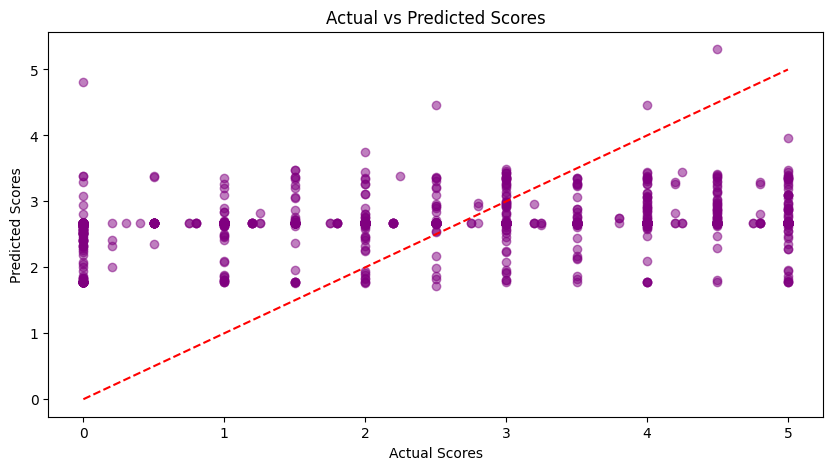

In [29]:
# Predictions vs Actual Scores
plt.figure(figsize=(10, 5))
plt.scatter(y_test, y_pred, alpha=0.5, color='purple')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='dashed')  # Ideal line
plt.xlabel('Actual Scores')
plt.ylabel('Predicted Scores')
plt.title('Actual vs Predicted Scores')
plt.show()

In [41]:
# Create a simple prediction function based on similarity metrics
def predict_score(student_answer, desired_answer):
    # Preprocess text
    student_answer_processed = preprocess_text(student_answer)
    desired_answer_processed = preprocess_text(desired_answer)
    
    # Calculate similarity metrics
    cosine_sim = compute_cosine_similarity(student_answer_processed, desired_answer_processed, tfidf_vectorizer)
    wmd_sim = compute_wmd(student_answer_processed, desired_answer_processed)
    
    # Normalize WMD (lower is better, so invert it)
    # Cap WMD at 10 to avoid extreme values
    normalized_wmd = max(0, min(1, 1 - (wmd_sim / 10)))
    
    # Formula: Weight cosine similarity more (0.7) than WMD (0.3)
    # Scale to 0-5 range which is common for scoring
    predicted_score = (cosine_sim * 0.7 + normalized_wmd * 0.3) * 5
    
    # Ensure score is within the expected range
    predicted_score = max(0, min(5, predicted_score))
    
    return predicted_score

# Test example
example_student_answer = "An array is a collection of elements stored in contiguous memory locations."
example_desired_answer = "An array is a collection of elements identified by an index."
predicted_score = predict_score(example_student_answer, example_desired_answer)
print(f"Predicted Score: {predicted_score}")

Predicted Score: 2.558519562724044


In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout, Conv1D, MaxPooling1D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.regularizers import l2

# 1. Handle Missing Values and Data Type:
df["Student_answer"] = df["Student_answer"].fillna("").astype(str)

# 2. Improved Tokenization with larger vocab:
max_words = 20000  # Increase vocabulary size
tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(df["Student_answer"])
X_sequences = tokenizer.texts_to_sequences(df["Student_answer"])

# 3. Padding with more context:
max_length = 150  # Increased from 100 to capture more context
X_padded = pad_sequences(X_sequences, maxlen=max_length, padding="post", truncating="post")

# 4. Target Variable:
y = df["score_avg"].fillna(df["score_avg"].mean()).astype(float)

# 5. Better train-test split with stratification on score ranges:
# Create score bins for stratification
import numpy as np
score_bins = np.floor(y).astype(int)
X_train, X_test, y_train, y_test = train_test_split(
    X_padded, y, test_size=0.2, random_state=42, stratify=score_bins
)

# 6. Improved Model Architecture:
vocab_size = min(len(tokenizer.word_index) + 1, max_words)  # +1 for <OOV>
embedding_dim = 200  # Increased embedding dimension

model = Sequential([
    # Input and Embedding
    Embedding(vocab_size, embedding_dim, input_length=max_length),
    
    # Convolutional layer for feature extraction
    Conv1D(128, 5, activation='relu', padding='same'),
    MaxPooling1D(pool_size=2),
    BatchNormalization(),
    
    # First Bidirectional LSTM layer
    Bidirectional(LSTM(128, return_sequences=True, recurrent_dropout=0.1)),
    Dropout(0.3),  # Increased dropout
    
    # Second Bidirectional LSTM layer
    Bidirectional(LSTM(64)),
    Dropout(0.3),  # Increased dropout
    
    # Dense layers with batch normalization for better generalization
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.3),
    
    Dense(32, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    
    # Output layer
    Dense(1, activation='linear')
])

# 7. Improved optimizer with weight decay
optimizer = Adam(learning_rate=0.001)
model.compile(
    optimizer=optimizer, 
    loss='huber',  # Huber loss is more robust to outliers than MSE
    metrics=['mae', 'mse']
)

# 8. Better callbacks
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=7,  # Increased patience
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.1,  # Sharper learning rate reduction
    patience=4, 
    min_lr=0.00001,
    verbose=1
)

# 9. Model training with class weighting
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=20,  # Slightly increased epochs since we have early stopping
    batch_size=64,  # Increased batch size for better generalization
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/20


C:\Users\Lenovo\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


116/116 ━━━━━━━━━━━━━━━━━━━━ 109s 783ms/step - loss: 2.2098 - mae: 2.5507 - mse: 9.1342 - val_loss: 1.5547 - val_mae: 1.8807 - val_mse: 5.1257 - learning_rate: 0.0010
Epoch 2/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 157s 914ms/step - loss: 1.2707 - mae: 1.5860 - mse: 3.9811 - val_loss: 0.8993 - val_mae: 1.1991 - val_mse: 2.1220 - learning_rate: 0.0010
Epoch 3/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 158s 1s/step - loss: 0.7902 - mae: 1.0800 - mse: 1.9225 - val_loss: 0.7993 - val_mae: 1.0977 - val_mse: 1.8555 - learning_rate: 0.0010
Epoch 4/20
 95/116 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - loss: 0.6371 - mae: 0.9149 - mse: 1.3985

In [46]:
# Evaluate model
y_pred = model.predict(X_test)  # Use X_test instead of X_test_lstm
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"R² Score: {r2}")

58/58 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step
Mean Squared Error: 1.7293509758693568
Mean Absolute Error: 1.028829210709104
R² Score: 0.3410722541764364


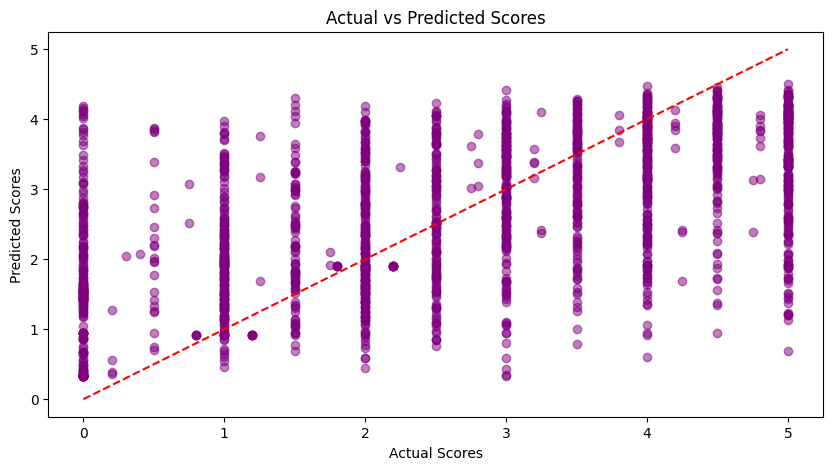

In [47]:
# Predictions vs Actual Scores
plt.figure(figsize=(10, 5))
plt.scatter(y_test, y_pred, alpha=0.5, color='purple')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='dashed')  # Ideal line
plt.xlabel('Actual Scores')
plt.ylabel('Predicted Scores')
plt.title('Actual vs Predicted Scores')
plt.show()

In [48]:
from tensorflow.keras.models import save_model

In [ ]:
# Assuming your model is named 'model'
model.save('sae.keras')

In [50]:
import pickle

In [51]:
# Assuming your model is named 'model'
with open('tokenizer1.pkl', 'wb') as file:
       pickle.dump(model, file)